# 画出预测图像

In [1]:
import torch as th
import numpy as np
import h5py

from task_datasets.sets.FLIR_2 import FLIRDataset
from task_datasets.sets.TNO import TNODataset

In [3]:
path = '/home/ZiHanCao/datasets/TNO'
ds = TNODataset(path, 'test', no_split=True)
dl = th.utils.data.DataLoader(ds, batch_size=1, shuffle=False)


In [4]:
import torch


from model.build_network import build_network

device = torch.device('cuda:0')
torch.cuda.set_device(device)

net=build_network('dcformer_mwsa', spectral_num=1, added_c=1, block_list=[4,[4,3],[4,3,2]],mode='C')
net.load_state_dict(
    # th.load('/home/ZiHanCao/exps/panformer/weight/dcformer_379zkf3e/ep_550.pth', map_location=device)['model']  # 2n8eo45b
    # th.load('./weight/dcformer_17rgbfmz/ep_490.pth', map_location=device)['model']
    th.load('./weight/dcformer_3l0px5zm/ep_260.pth', map_location=device)['model']
)
net=net.cuda()

path_size: 64


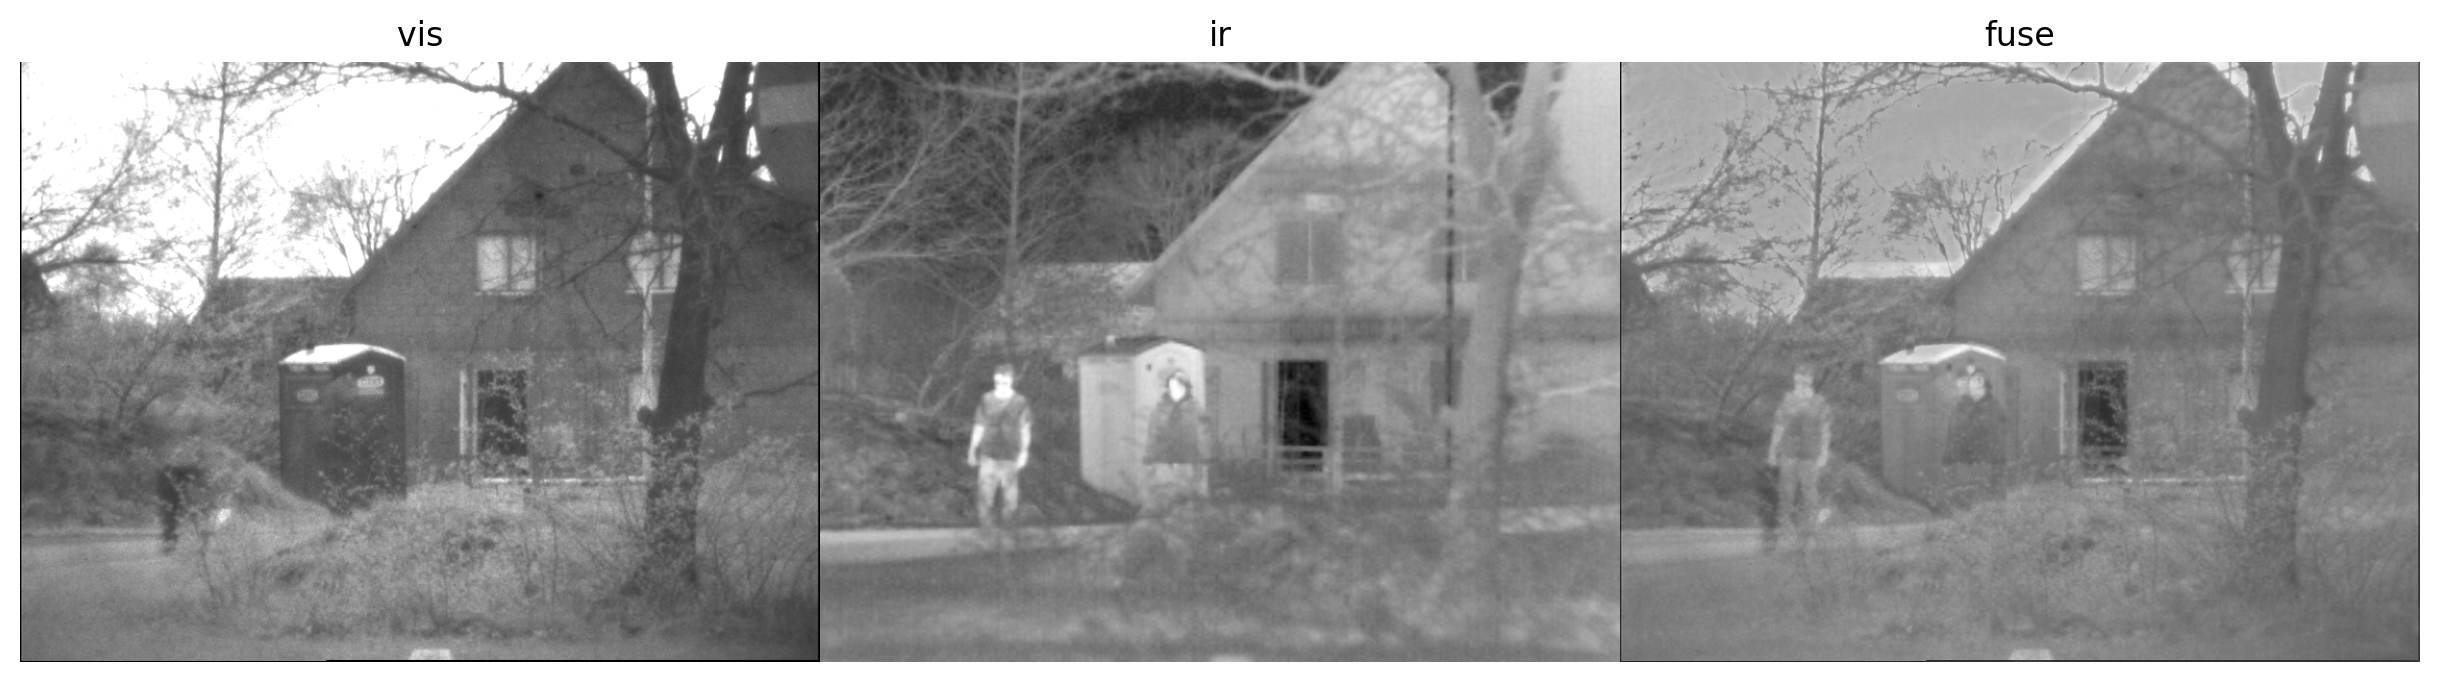

(576, 768, 1) img saved to ./visualized_img/ir/0.bmp


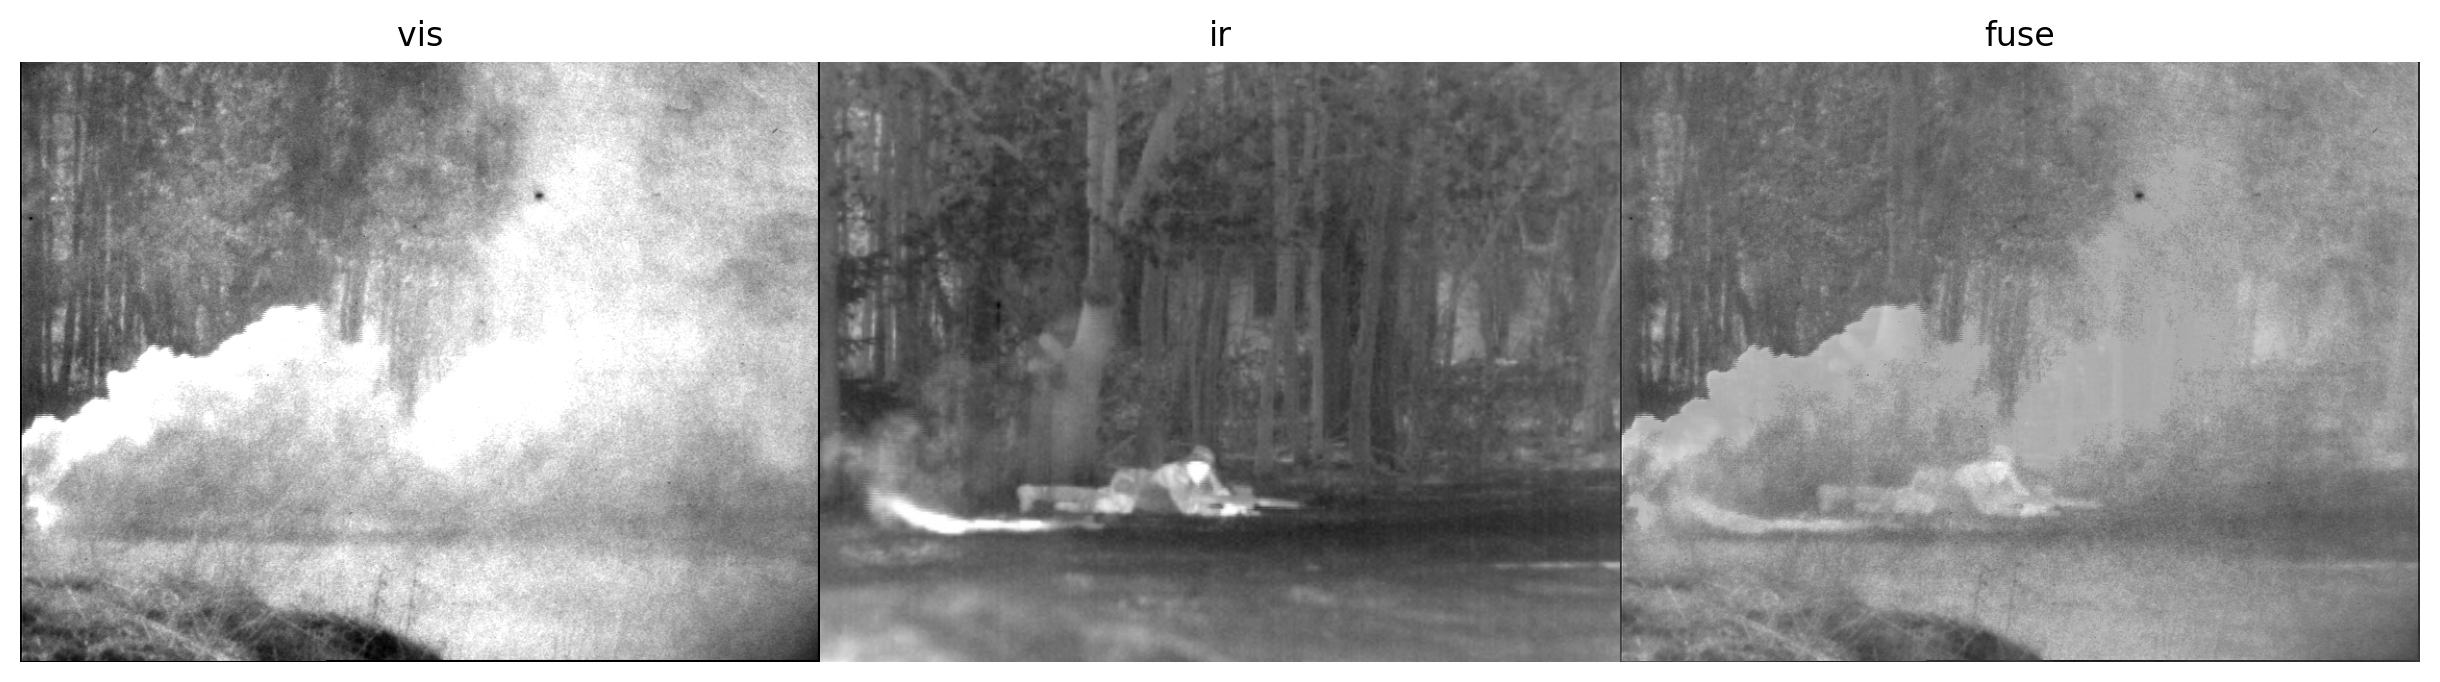

(576, 768, 1) img saved to ./visualized_img/ir/1.bmp


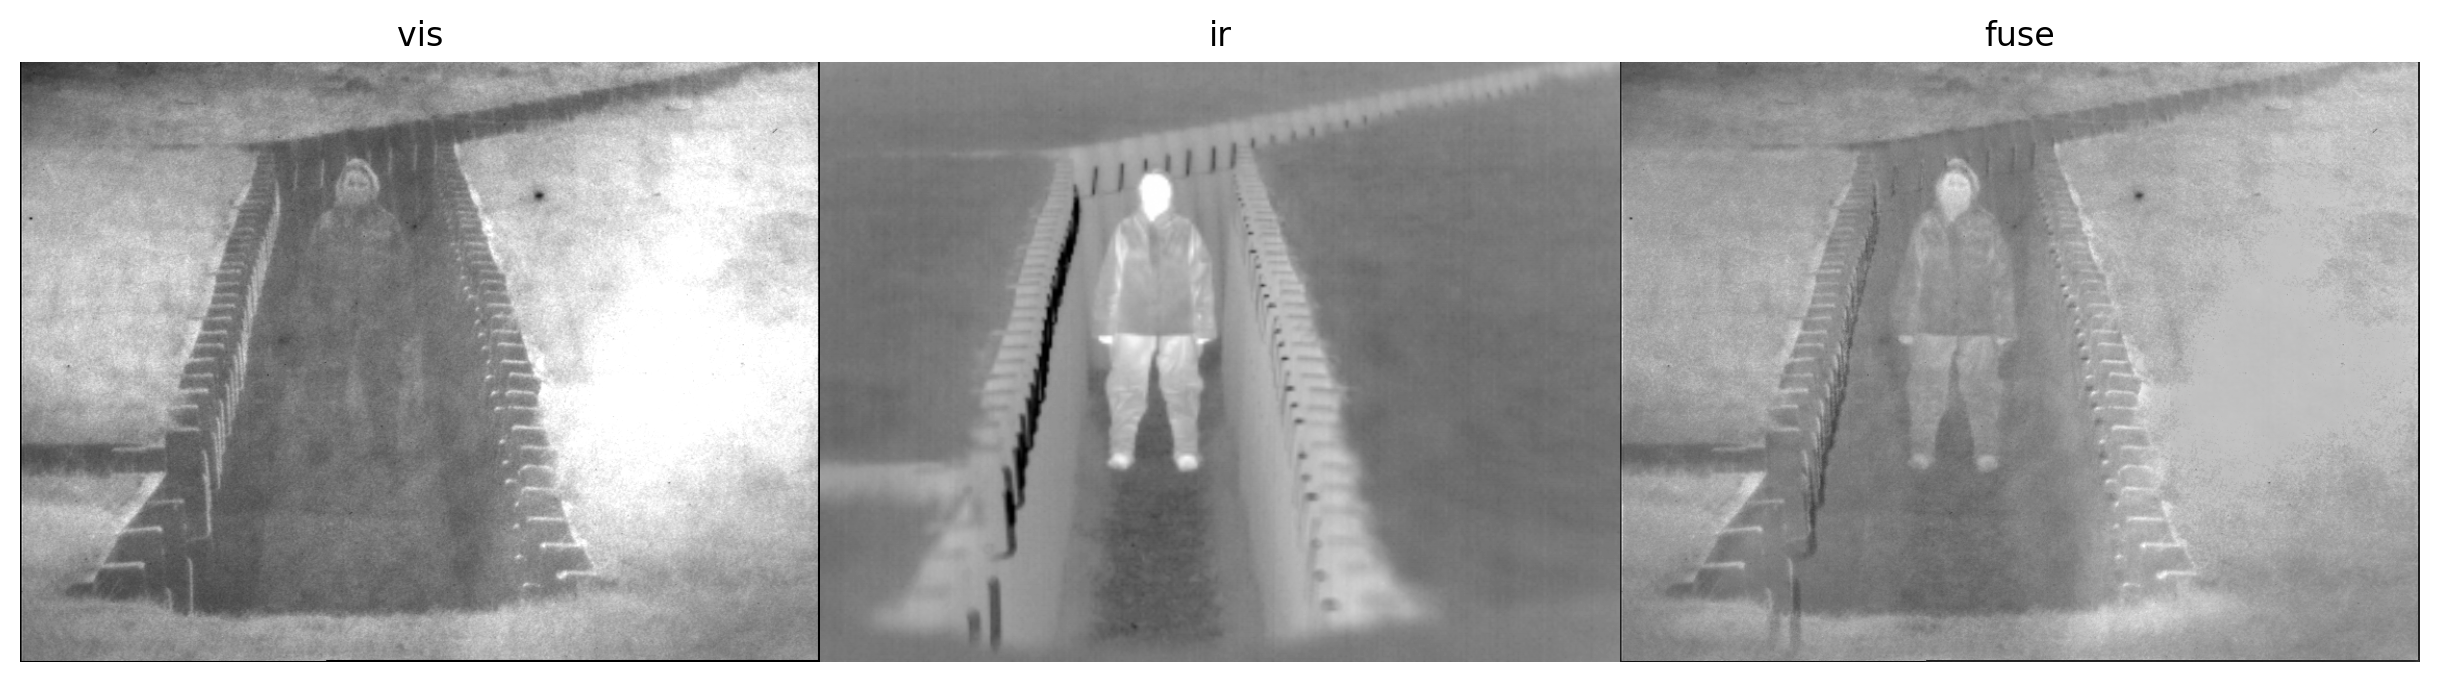

(576, 768, 1) img saved to ./visualized_img/ir/2.bmp


KeyboardInterrupt: 

In [5]:
import torch
import torch.nn.functional as F
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from scipy.io import savemat
import cv2

from model.base_model import PatchMergeModule

def convert_uint8(img):
    print(img.shape, end=' ')
    if img.dtype != np.uint8:
        img = img.clip(0, 1)
        img *= 255
        # print('convert to [0, 255]')
    return img.astype(np.uint8)

net.eval()
patch_merge_net = PatchMergeModule(net, 1, patch_size=64, scale=1)
with th.no_grad():
    for i, (ir, ms, vis, gt) in enumerate(dl):
        ir, ms, vis, gt = ir.cuda(), ms.cuda(), vis.cuda(), gt.cuda()
        
        spa_size = gt.shape[-2:]
        pan_nc = ir.size(1)
        ms_nc = ms.size(1)
        input = (
            F.interpolate(ms, size=tuple(vis.shape[-2:]), mode='bilinear', align_corners=True),
            vis,
            torch.cat([ir, torch.zeros(1, ms_nc - pan_nc, *spa_size).cuda()], dim=1)
        )
        sr = patch_merge_net.forward_chop(*input)[0]
        sr = sr.detach().cpu().numpy()[0]
        sr_show = sr.transpose([1, 2, 0])
        vis_show = vis.detach().cpu().numpy()[0].transpose([1, 2, 0])
        ir_show = ir.detach().cpu().numpy()[0].transpose([1, 2, 0])
        
        fig, axes = plt.subplots(ncols=3, figsize=(12, 4), dpi=200)
        axes = axes.flatten()
        
        for img, name, ax in zip([vis_show, ir_show, sr_show],
                                 ['vis', 'ir', 'fuse'],
                                 axes):
            ax.imshow(img, 'gray')
            ax.set_axis_off()
            ax.set_title(name)
        
        plt.subplots_adjust(wspace=0, hspace=0)
        plt.tight_layout(pad=0)
        plt.show()
        
        sr_show = convert_uint8(sr_show)
        cv2.imwrite(f'./visualized_img/ir/{i}.bmp', sr_show)
        print('img saved to {}'.format(f'./visualized_img/ir/{i}.bmp'))
        
        # mat=dict(
        #     fuse=convert_uint8(sr_show),
        #     vis=convert_uint8(vis_show),
        #     ir=convert_uint8(ir_show)
        # )
        # mat_path = f'./visualized_img/ir/{i}.mat'
        
        # savemat(mat_path, mat)
        # print('mat file saved to {}'.format(mat_path))
        
        # raw_ir = ir
        # y=net.val_step(ms.to('cuda:1'), ir.to('cuda:1'), vis.to('cuda:1'))
        # y_show=make_grid(y.detach().cpu(), nrow=4).numpy()
        # vis=make_grid(vis, nrow=4).numpy()
        # ir=make_grid(ir, nrow=4).numpy()
        
        # print(th.abs((y.detach().cpu()-raw_ir)).sum())
        # print(y_show.min(), y_show.max())
        
        # ys = np.concatenate([vis, ir, y_show], axis=2)
        
        # ax=plt.gca()
        # ax.set_axis_off()
        # plt.gcf().set_dpi(300)
        # plt.gcf().set_size_inches(4, 4*3)
        # plt.tight_layout(pad=0)
        # ax.imshow(ys.transpose(1,2,0))
        # plt.show()

In [ ]:
from scipy.io import savemat, loadmat

path = r'./visualized_img/ir/data_2.mat'
mat_d = loadmat(path)
fuse = mat_d['fuse']
np.min(fuse)

50

In [47]:
x=np.random.randn(3, 64, 64)
y=np.random.randn(3, 64, 64)

np.concatenate([x,y], axis=-1).shape

(3, 64, 128)

# 可视化attention

In [47]:
import torch
import torch.nn.functional as F
import numpy as np
import h5py

from model.module.attention import MultiScaleWindowCrossAttention, CAttention
from model.module.swin import window_partition
from model.module.helper_func import exists
from model.dcformer_mwsa import DCFormerMWSA

from task_datasets.sets.HISR import HISRDataSets

In [3]:
net = DCFormerMWSA(spectral_num=31, added_c=3, block_list=[4,[4,3],[4,3,2]],mode='C')#.cuda(1)
net.eval()

path = "/home/ZiHanCao/datasets/HISI/new_cave/test_cave(with_up)x4.h5"
ds = HISRDataSets(h5py.File(path))


concat head
dataset shape:
       lr_hsi              hsi_up               rgb                  gt         
 (11, 31, 128, 128)  (11, 31, 512, 512)  (11, 3, 512, 512)   (11, 31, 512, 512) 


In [48]:
from einops import rearrange

CATTEN_LIST = []
CATTN_OUT_LIST = []
MWSA_ATTN_LIST = []
MWSA_ATTN_OUT_LIST = []
GHOST_OUT_LIST = []

def cattention_hook(m, inp, outp):
    # calcu attn again
    x = inp[0]
    with torch.no_grad():
        qkv = m.qkv_dwconv(m.qkv(x))
        q, k, v = qkv.chunk(3, dim=1)

        q = rearrange(q, "b (head c) h w -> b head c (h w)", head=m.num_heads)
        k = rearrange(k, "b (head c) h w -> b head c (h w)", head=m.num_heads)
        v = rearrange(v, "b (head c) h w -> b head c (h w)", head=m.num_heads)

        q = torch.nn.functional.normalize(q, dim=-1)
        k = torch.nn.functional.normalize(k, dim=-1)
        attn = (q @ k.transpose(-2, -1)) * m.temperature
        attn = attn.softmax(dim=-1)
    
    CATTEN_LIST.append(attn.detach().cpu().numpy())
    CATTN_OUT_LIST.append(outp.detach().cpu().numpy())
    
def mwsa_attn_hook(m, inp, outp):
    tgt, mem = inp
    with torch.no_grad():
        if not exists(m.window_size1) and not exists(m.window_size2):
                m.window_size1 = m.window_dict[tgt.size(-1)]
                m.window_size2 = m.window_dict[mem.size(-1)]

        b, c, h, w = tgt.shape
        mem = m.match_c(mem)
        q = window_partition(
            tgt.permute(0, 2, 3, 1), m.window_size1
        )  # [nw*b, wh1, ww1, c]
        kv = window_partition(
            mem.permute(0, 2, 3, 1), m.window_size2
        )  # [nw*b, wh2, ww2, c]

        q = m.q(q)
        kv = m.kv(kv)
        k, v = kv.chunk(2, dim=-1)

        # assert tgt.size(0) == mem.size(0)

        # q: [b*nw, nh, wh1*ww1, c]
        # k, v: [b*nw, nh, wh2*ww2, c]
        q = rearrange(q, "b h w (head c) -> b head (h w) c", head=m.num_heads)
        k = rearrange(k, "b h w (head c) -> b head (h w) c", head=m.num_heads)
        v = rearrange(v, "b h w (head c) -> b head (h w) c", head=m.num_heads)

        q = F.normalize(q, dim=-1)
        k = F.normalize(k, dim=-1)

        # [b*nw, nh, wh1*ww1, wh2*ww2]
        attn = (q @ k.transpose(-2, -1)) * m.temperature

        attn = attn.softmax(-1)
        ghost_out = m.ghost_module(
            torch.cat([tgt, F.interpolate(mem, tgt.shape[-1], mode="bilinear")], dim=1)
        )
    MWSA_ATTN_LIST.append(attn.detach().cpu().numpy())
    MWSA_ATTN_OUT_LIST.append(outp.detach().cpu().numpy())
    GHOST_OUT_LIST.append(ghost_out.detach().cpu().numpy())
    
    

In [49]:
c_attn_handlers = []
mwsa_attn_hooks = []

for m in net.modules():
    if isinstance(m, CAttention):
        h = m.register_forward_hook(cattention_hook)
        c_attn_handlers.append(h)
        print('c attention hook')
    
    if isinstance(m, MultiScaleWindowCrossAttention):
        h = m.register_forward_hook(mwsa_attn_hook)
        mwsa_attn_hooks.append(h)
        print('mwsa attention hook')
        
        
def remove_all_hooks(hs):
    for h in hs:
        h.remove()
        

c attention hook
c attention hook
c attention hook
c attention hook
c attention hook
c attention hook
mwsa attention hook
c attention hook
mwsa attention hook
mwsa attention hook
c attention hook
c attention hook
c attention hook
c attention hook
c attention hook
c attention hook
c attention hook
mwsa attention hook
mwsa attention hook
mwsa attention hook
mwsa attention hook
mwsa attention hook
mwsa attention hook


In [9]:
remove_all_hooks(c_attn_handlers)

In [50]:
dl = torch.utils.data.DataLoader(ds, batch_size=1, shuffle=False)

In [51]:
pan, ms, lms, gt = next(iter(dl))

out = net.val_step(ms.float(),#.cuda(1),
                   lms.float(),#.cuda(1),
                   pan.float())#.cuda(1))

In [52]:

# norm to [0, 1]
def norm(x):
    return (x - x.min()) / (x.max() - x.min())

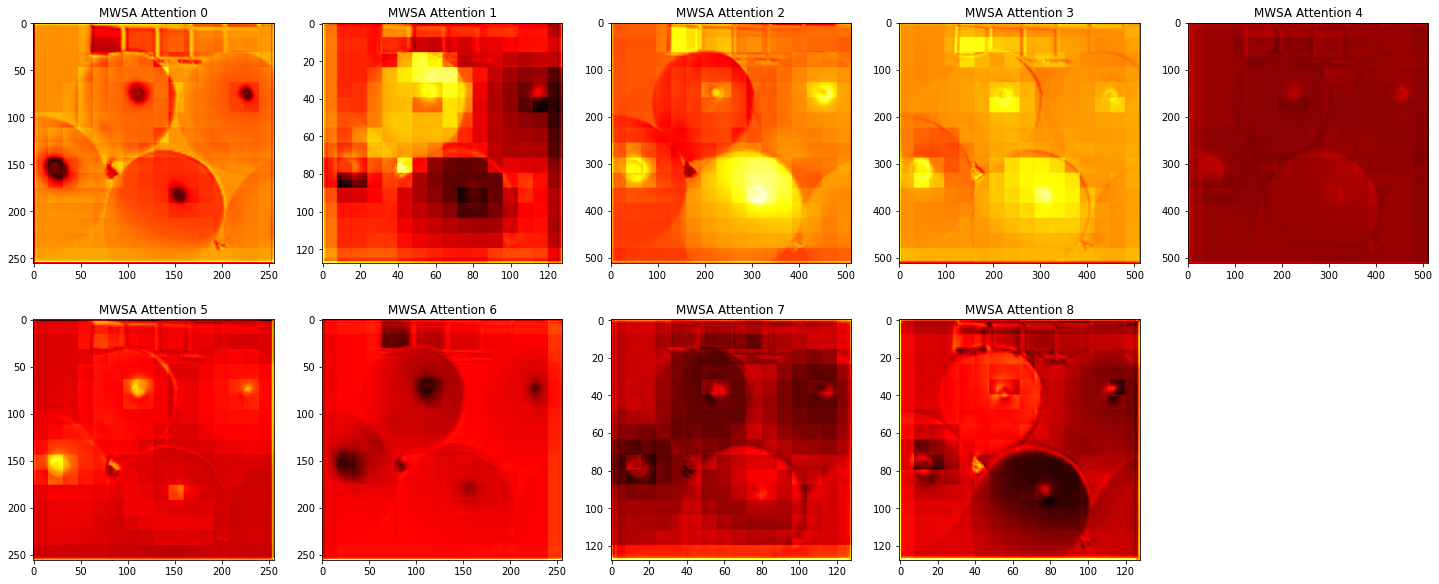

In [95]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 5, figsize=(25, 10))
axes = axes.flatten()
for i, c in enumerate(MWSA_ATTN_OUT_LIST):
    c = c.mean(1)[0]
    # c = c[0, 5]
    axes[i].imshow(norm(c), 'hot')
    # axes[i].set_axis_off()
    axes[i].set_title(f'MWSA Attention {i}')
    
axes[-1].set_axis_off()

In [94]:
MWSA_ATTN_OUT_LIST[0].shape

(1, 64, 256, 256)

# sailency map

In [ ]:
import numpy as np
import torch as th
import PIL.Image as pim

from sailency import LAM


In [ ]:

LAM()

# aim use

In [ ]:
!pip install aim

In [24]:
from aim import Run, Repo, Image

run = Run(experiment='test')


In [38]:
repo = Repo('./')

repo.list_all_runs()
repo.delete_run('d41840cf5c4c434fbcb49300')

True

In [49]:
import numpy as np

for i in range(1000):
    j = np.exp(i * 0.001)
    run.track(j, 'loss_v2', step=i, context={'subset': 'test/v2'})

In [41]:
run['hparams'] = {
    'lr': 0.001,
    'total_eps': 100
}

In [44]:
from aim import Distribution
import torch

guassian_dist = torch.randn(1, 1000)

dist = Distribution(guassian_dist)
run.track(dist, name='guassian_dist', context={'train': 'dist'}, step=10)

In [52]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

img = torch.randn(10, 3, 256, 256)

aim_imgs = Image(make_grid(img))

run.track(aim_imgs, name='img', context={'train': 'img'}, step=10)

In [45]:
run.log_info('This is a log message')

In [29]:
run.finalize()

In [1]:
!aim up

'/Data2/ZiHanCao/exps/panformer' is not a valid Aim repository. Do you want to initialize it? [y/N]: ^C
Aborted!


In [1]:
from utils.log_utils import AimLogger

logger = AimLogger('test_aim_v2', hparams={'net_name': 'test_net'}, desp='this is a test')

In [3]:
logger.run.hash

'a91569c955da474c9e09a40a'

Exception in thread Thread-5:
Traceback (most recent call last):
  File "/home/ZiHanCao/.conda/envs/zihan/lib/python3.9/threading.py", line 973, in _bootstrap_inner
    self.run()
  File "/home/ZiHanCao/.conda/envs/zihan/lib/python3.9/threading.py", line 910, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ZiHanCao/.conda/envs/zihan/lib/python3.9/site-packages/aim/sdk/reporter/__init__.py", line 812, in _run
    self.touch_path.touch(exist_ok=True)
  File "/home/ZiHanCao/.conda/envs/zihan/lib/python3.9/pathlib.py", line 1315, in touch
    fd = self._raw_open(flags, mode)
  File "/home/ZiHanCao/.conda/envs/zihan/lib/python3.9/pathlib.py", line 1127, in _raw_open
    return self._accessor.open(self, flags, mode)
FileNotFoundError: [Errno 2] No such file or directory: '/Data2/ZiHanCao/exps/panformer/.aim/meta/progress/a91569c955da474c9e09a40a'
Exception in thread Thread-6:
Traceback (most recent call last):
  File "/home/ZiHanCao/.conda/envs/zihan/lib/python3.9/threadin

In [ ]:
logger.log_text('nothing', 'try again')

In [ ]:
import numpy as np
import torch

for _ in range(100):
    a = torch.randn(1, 2000)
    logger.log_distribution(a, 'test_dist')

In [ ]:
distribution = a.flatten()

if isinstance(distribution, torch.Tensor):
    distribution = distribution.detach().cpu().numpy()
    
hist, bins = np.histogram(distribution, bins=64 if 64 < len(distribution) else len(distribution))
# bin range is
bin_range = [bins[0], bins[-1]]

logger.run.track(
    aim.Distribution(hist=hist, bin_range=bin_range), name='12345', epoch=10
)

In [26]:
import torch
import aim

conv = torch.nn.Sequential(torch.nn.Conv2d(3, 3, 3), torch.nn.Linear(3, 6))

for n, p in conv.named_parameters():
    p = p.flatten().detach().cpu().numpy()
    print(n, type(p), p.shape)
    # logger.log_distribution(p, name=n)
    hist, bins = np.histogram(p, bins=64 if 64 < len(p) else len(p))
        # bin range is
    bin_range = [bins[0], bins[-1]]

    logger.run.track(
        aim.Distribution(p), name='network', context=n
    )
# logger.log_network(conv)

0.weight <class 'numpy.ndarray'> (81,)
0.bias <class 'numpy.ndarray'> (3,)
1.weight <class 'numpy.ndarray'> (18,)
1.bias <class 'numpy.ndarray'> (6,)


In [5]:
logger.log_metrics(dict(a=1, b=2))

In [11]:
# logger.log_text('asdg3dsgnbnef', name='show')

import matplotlib.pyplot as plt
import numpy as np

from aim import Image

# plt.imshow(np.random.randn(256, 256))
# fig = plt.gcf()

# img = np.random.randn(256, 256)

img = torch.randint(0, 255, (3, 256, 256), dtype=torch.uint8)

# logger.run.track(Image(img), name='1234')

for i in range(10):
    for j in range(10):
        # logger.log_image(img, name='figs', context={'train': 'figs'}, epoch=i)
        logger.run.track(Image(img), name='figs', context={'train': 'figs'}, step=i)

In [20]:
from PIL import Image as PImage

np.array(PImage.fromarray(img, 'L'))

array([[ 80, 131, 120, ...,  78, 220, 191],
       [ 75,  81, 147, ..., 219, 244,  63],
       [160,   1,  12, ..., 162, 218,  63],
       ...,
       [ 33, 250,  58, ...,  86, 203, 191],
       [228, 226, 134, ..., 166, 241, 191],
       [ 12,  46, 232, ..., 197, 236, 191]], dtype=uint8)

In [5]:
logger.close()

logger closed


In [37]:
logger.run.hash

'7b45be102ee542c88d87959e'

In [ ]:

print(logger.repo.list_all_runs())
for run in logger.repo.list_all_runs():
    run = logger.repo.get_run(run)
    run.read_only = False
    print(run.read_only)
    logger.repo.delete_run(logger.run.hash)

In [2]:
import pickle

with open('./train_status/status.pkl', 'rb') as f:
    d = pickle.load(f)

In [8]:
d[-1]

{'id': '2e2wgxc1',
 'status': 'break',
 'time_stamp': '1690376200.737417',
 'time': '2023-07-26, 20:56:40',
 'args': optimizer: 
   name: adamw
   lr: 0.001
   weight_decay: 1e-06
 lr_scheduler: 
   name: multi_step
   milestones: [100, 800]
   gamma: 0.1
 max_norm: 0.3
 path: 
   train_path: /Data2/ZiHanCao/datasets/pansharpening/qb/training_qb/train_qb.h5
   val_path: /Data2/ZiHanCao/datasets/pansharpening/qb/reduced_examples/test_qb_multiExm1.h5
 network_configs: 
   dcformer_base: 
     spectral_num: 8
     mode: C
   dcformer_dpw: 
     spectral_num: 8
     mode: C
   dcformer_woo: 
     spectral_num: 8
     mode: C
   dcformer_dynamic: 
     spectral_num: 8
     mode: C
   dcformer_reduce: 
     spectral_num: 31
     block_list: [4, [4, 3], [4, 3, 2]]
     mode: C
     added_c: 3
   dcformer_mwsa: 
     spectral_num: 31
     block_list: [4, [4, 3], [4, 3, 2]]
     mode: C
     added_c: 3
   dcformer_mwsa_new: 
     spatial_size: 64
     spectral_num: 4
     added_c: 1
     mode: 